In [1]:
import os
import sys

sys.path.insert(0, os.path.relpath("../../../../.."))

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import (
    SuperSimulationFactory,
)
from recidiviz.calculator.modeling.population_projection.transition_table import (
    TransitionTable,
)
from recidiviz.calculator.modeling.population_projection.shell_compartment import (
    ShellCompartment,
)
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from functools import partial
import yaml

In [2]:
%run ../../../../../../recidiviz-research/utils/research_utils.py

/Users/justine/recidiviz-research/utils/research_utils.py:37: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext google.cloud.bigquery")
/Users/justine/recidiviz-research/utils/research_utils.py:38: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/Users/justine/recidiviz-research/utils/research_utils.py:39: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")  # 2 => reload ALL modules on every code run


In [3]:
adjust_plot_scale(0.4)

In [4]:
policy_sim = SuperSimulationFactory.build_super_simulation(
    "../state/MA/raise_the_age/MA_raise_the_age_inputs.yaml"
)

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 589.26rows/s]


In [5]:
# Policy functions

## ASSUMPTIONS
# Policy starts Jan 2023 for 18, Jan 2025 for 19, Jan 2027 for 20


policy_transitions = pd.read_csv(
    "../state/MA/raise_the_age/New MA data - policy transitions.csv"
)


def change_dys_transitions(policy_transitions, compartment):
    alternate_transitions = policy_transitions[
        policy_transitions["compartment"] == compartment
    ].copy()
    return partial(
        TransitionTable.use_alternate_transitions_data,
        alternate_historical_transitions=alternate_transitions,
        retroactive=False,
    )


# Reference dates is Nov 2021, so Jan 2023 first policy ts = 14
# policy_ts_map = {age: policy_ts}
policy_ts_map = {18: 14, 19: 38, 20: 62}

policy_list = [
    SparkPolicy(
        policy_fn=change_dys_transitions(policy_transitions, compartment),
        spark_compartment=compartment,
        sub_population={"age": str(age)},
        policy_ts=policy_ts,
        apply_retroactive=False,
    )
    for age, policy_ts in policy_ts_map.items()
    for compartment in policy_transitions["compartment"].unique()
]

initialization time:  8.655658960342407
initialization time:  6.762959003448486
simulation_time:  19.624846935272217
simulation_time:  21.038621187210083
235.4


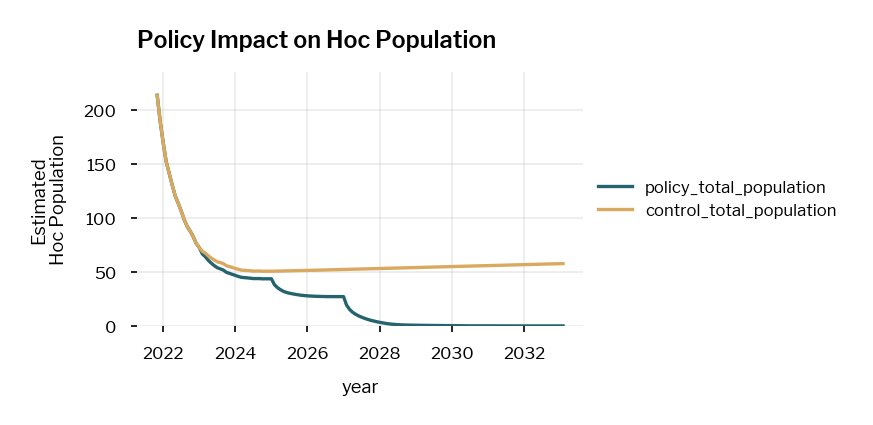

In [6]:
policy_results = policy_sim.simulate_policy(policy_list, "HOC")
add_legend()

In [7]:
simulation_tag = "control"  # "baseline_projections" #
baseline_projection = policy_sim.get_population_simulations()[
    simulation_tag
].get_population_projections()
baseline_outflows = policy_sim.get_population_simulations()[
    simulation_tag
].get_outflows()
data_inputs = policy_sim.initializer.get_data_inputs()

In [9]:
df.set_index(["time_step"])

,compartment,total_population,simulation_group
time_step,,,
-50,release_full,0.000000,18
-49,release_full,0.000000,18
-48,release_full,107.229961,18
-47,release_full,217.319388,18
-46,release_full,310.252021,18
...,...,...,...
131,release_full,12790.996253,20
132,release_full,12828.201400,20
133,release_full,12864.477306,20


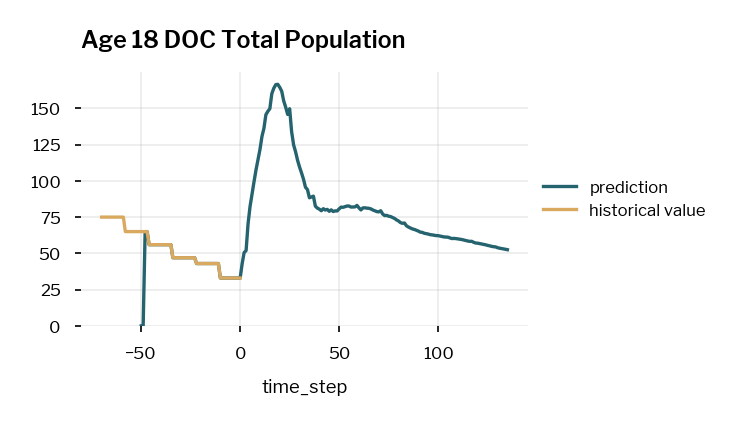

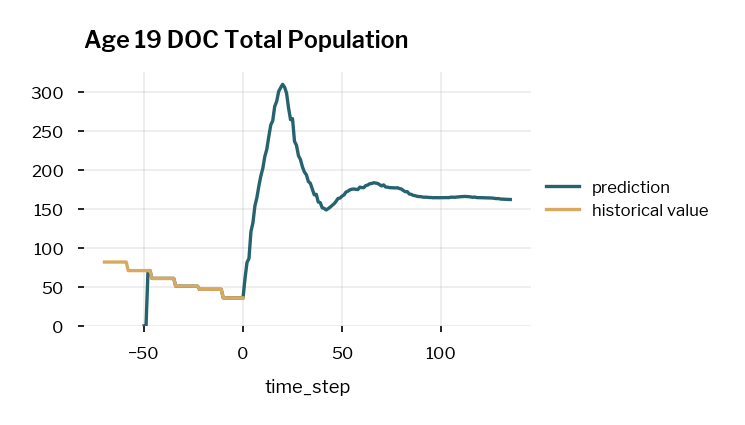

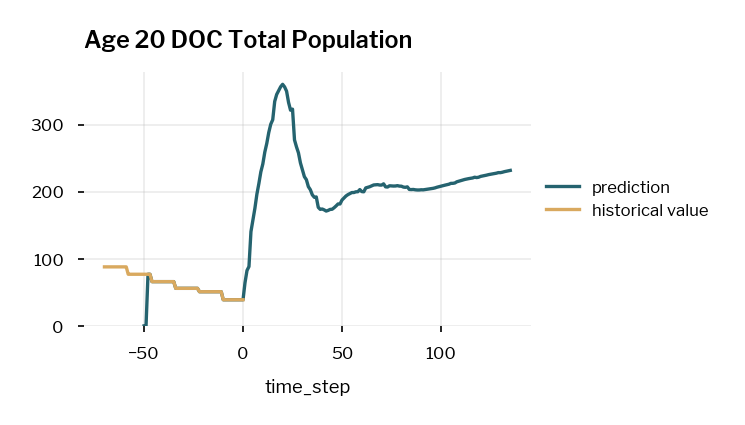

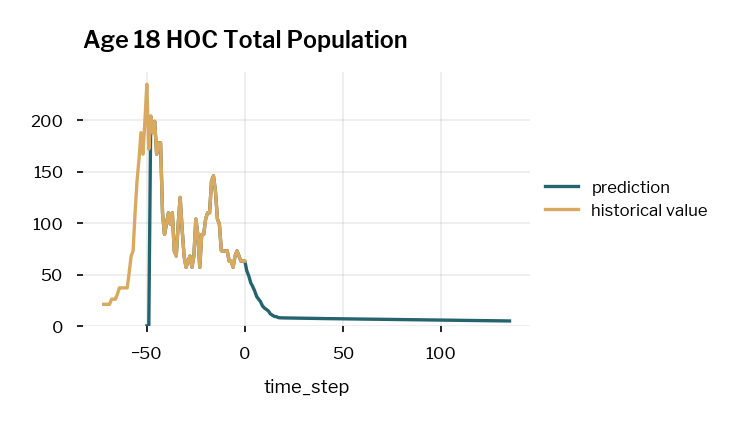

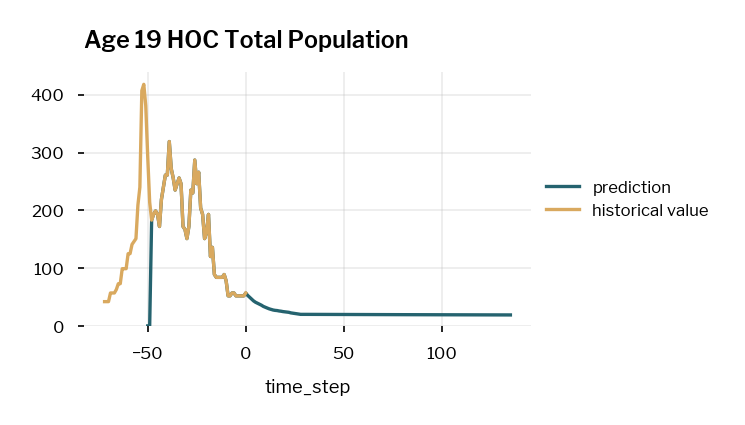

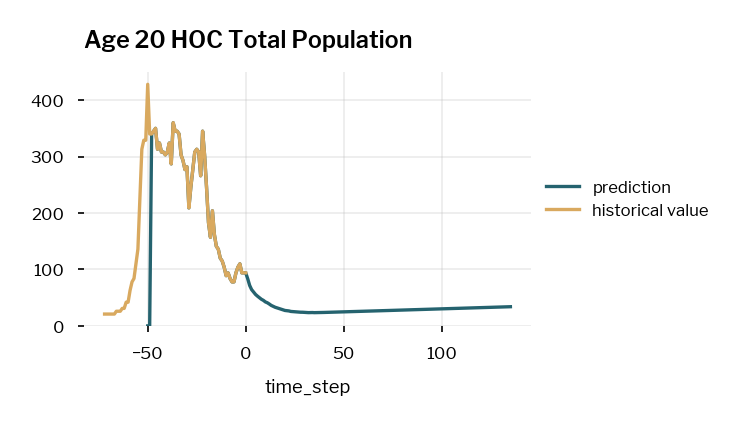

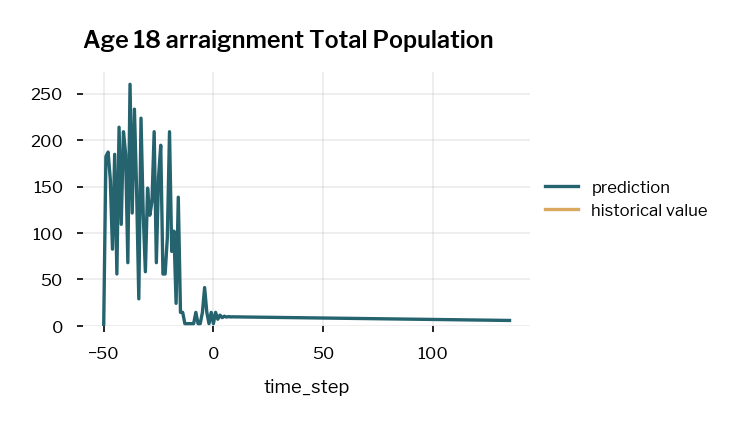

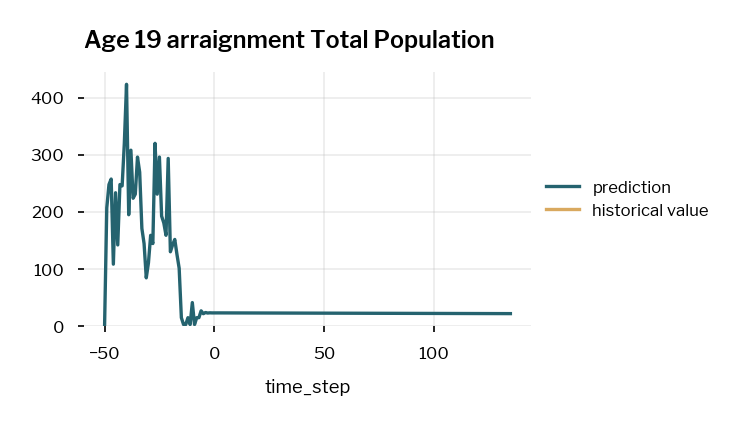

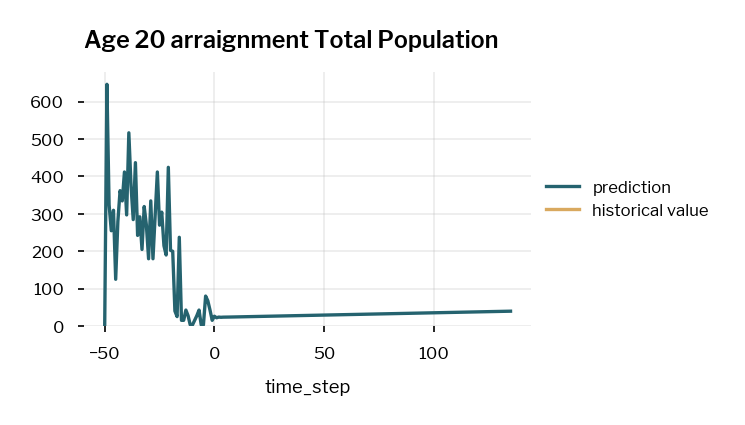

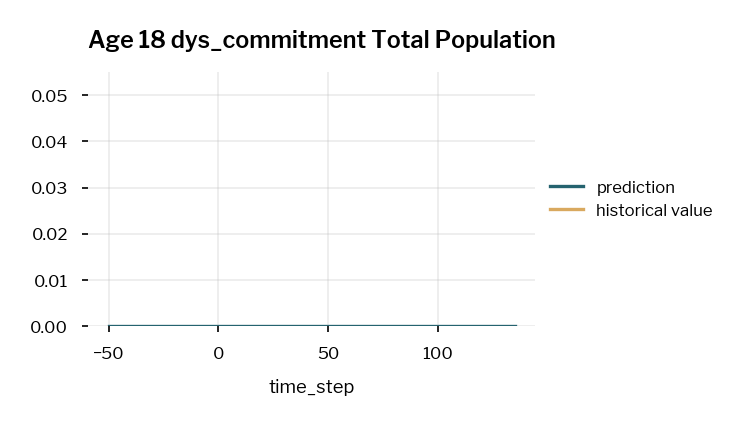

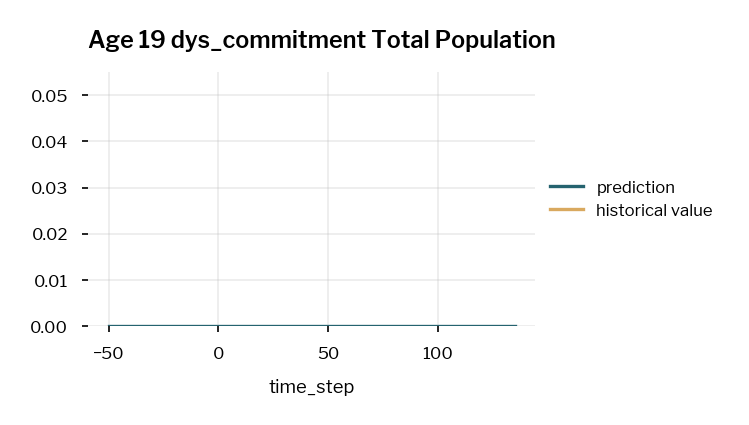

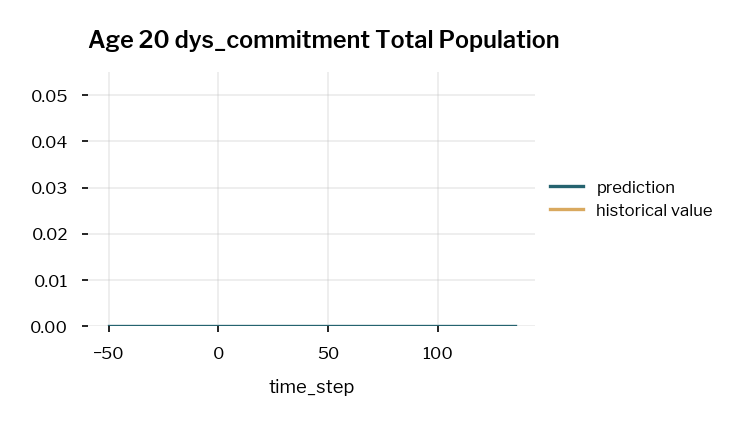

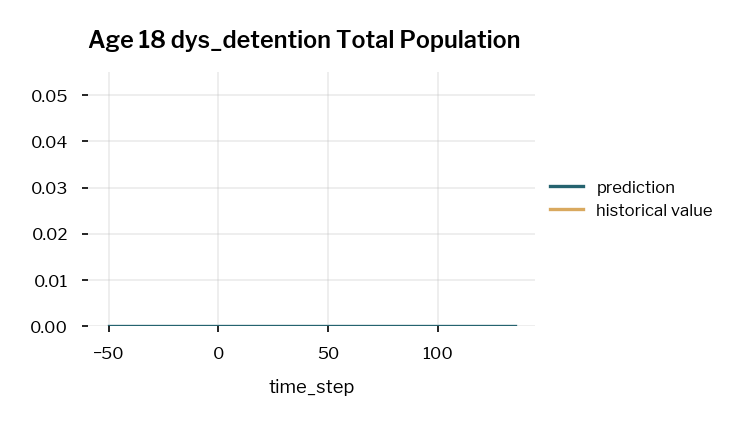

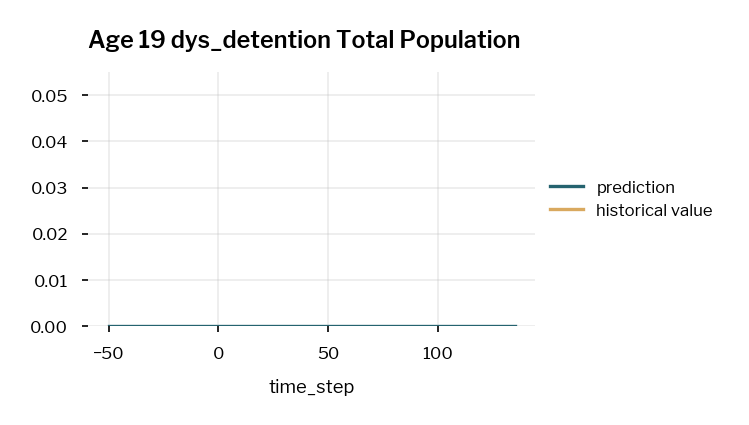

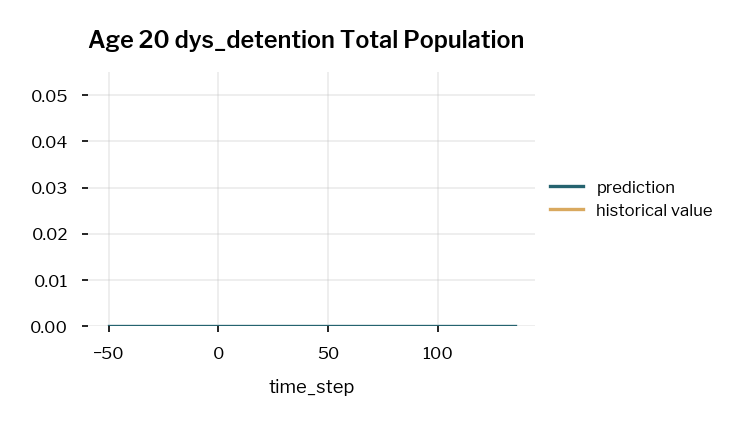

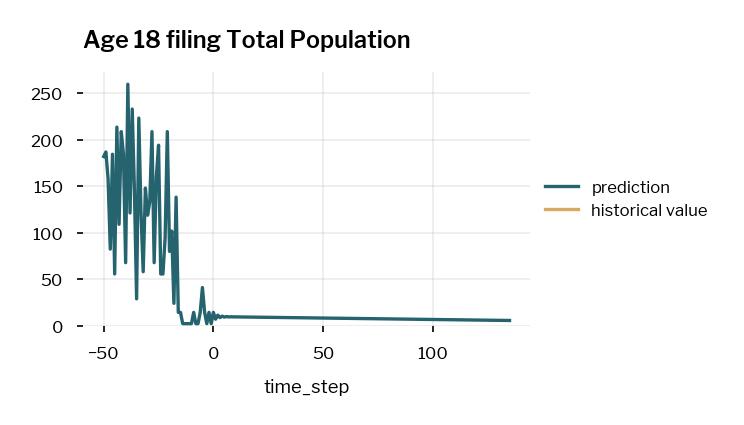

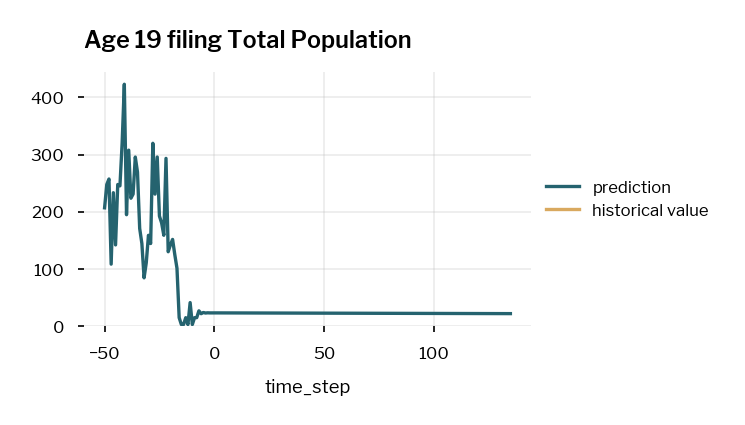

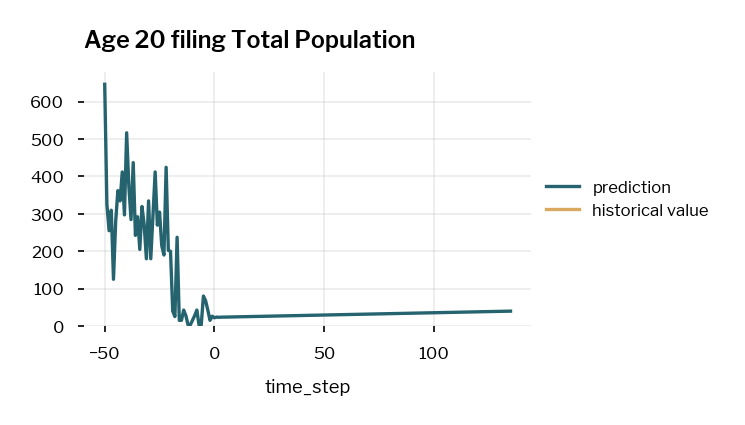

In [17]:
total_population = data_inputs.total_population_data

for compartment, df in baseline_projection.groupby("compartment"):
    if "release" in compartment:
        continue

    for age, group in df.groupby("simulation_group"):
        plt.figure()
        group.set_index(["time_step"])["total_population"].plot(label="prediction")

        compartment_pop = total_population[
            (total_population["compartment"] == compartment)
            & (total_population["age"] == age)
        ]
        compartment_pop.groupby(["time_step"])["total_population"].sum().plot(
            label="historical value"
        )

        add_legend()
        plt.title(f"Age {age} {compartment} Total Population")
        plt.ylim([0, None])

initialization time:  8.70121717453003
initialization time:  7.502346992492676
simulation_time:  22.6428439617157
simulation_time:  20.628387928009033
235.4


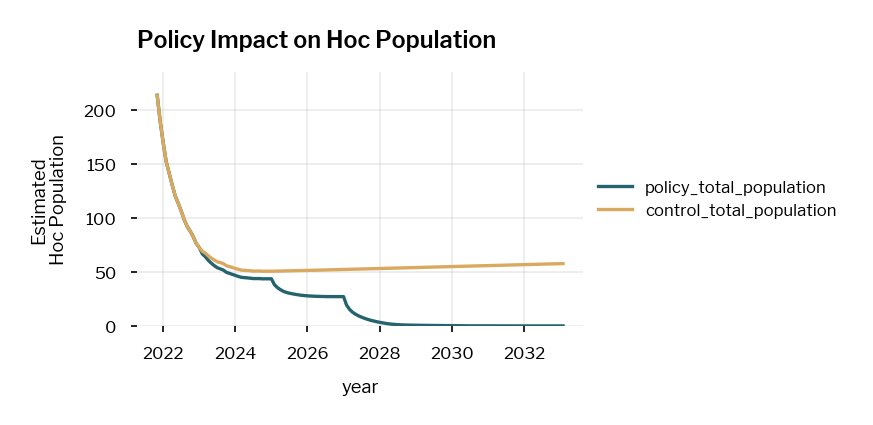

In [85]:
policy_results = policy_sim.simulate_policy(policy_list, "HOC")
add_legend()

In [89]:
simulation_tag = "ma_s920"
results_dict = policy_sim.upload_policy_simulation_results_to_bq(simulation_tag)

../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:333: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:333: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:333: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3609.56it/s]


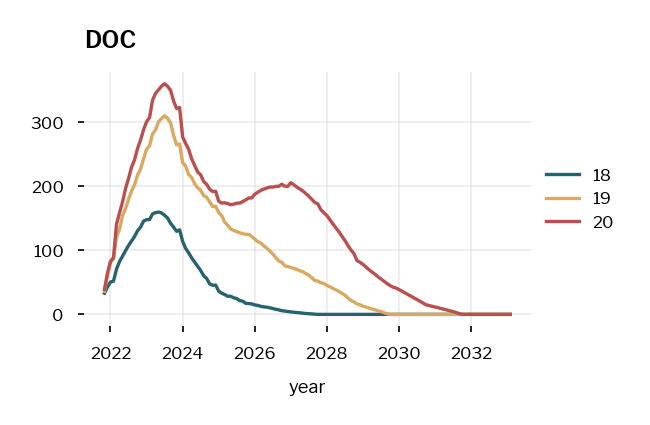

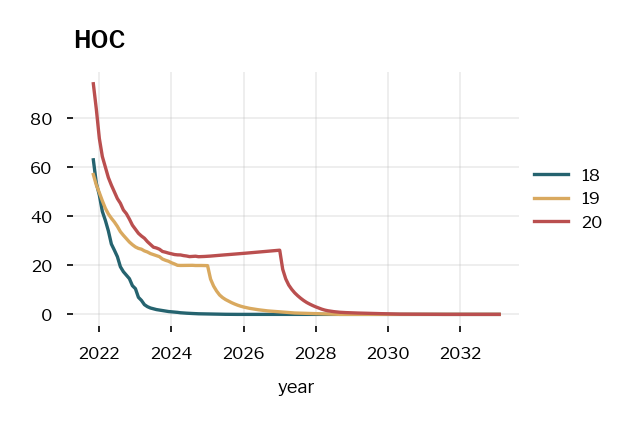

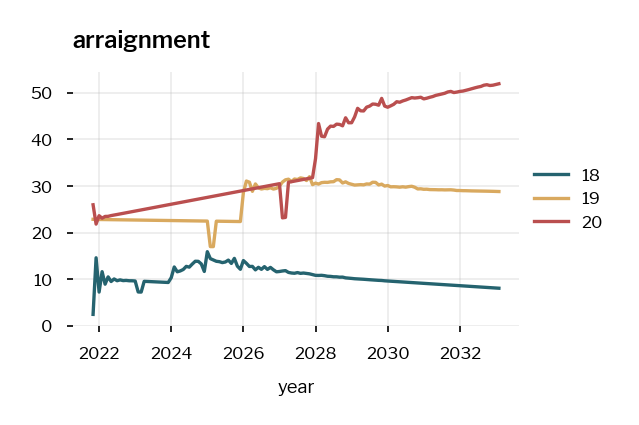

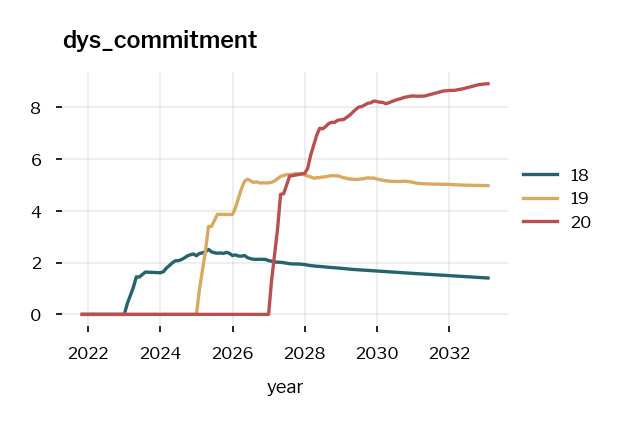

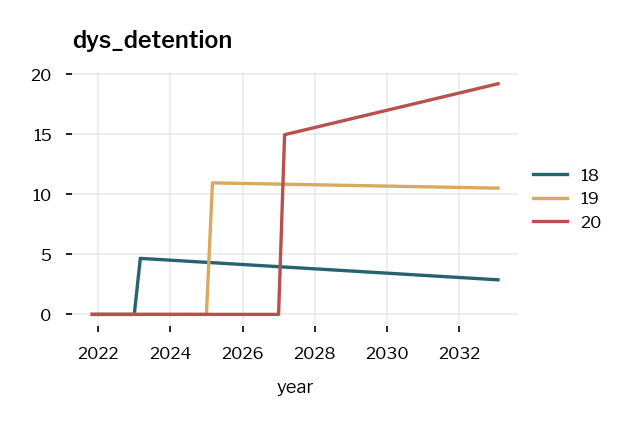

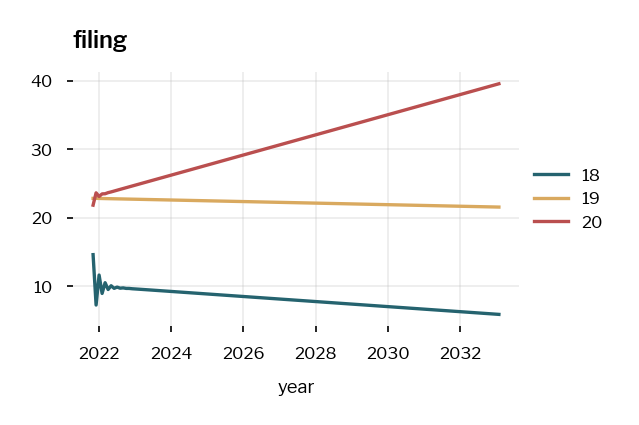

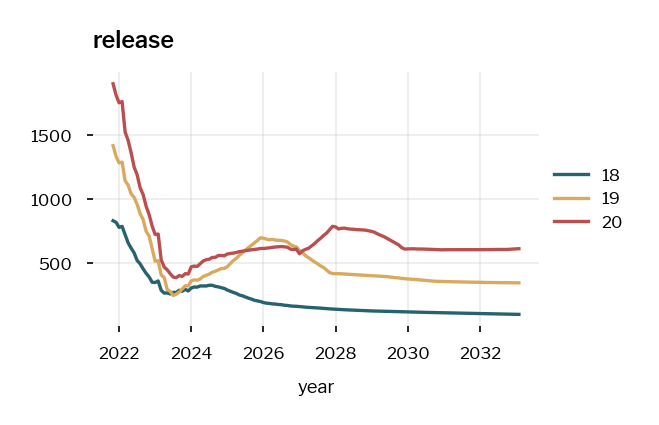

In [86]:
for compartment, df in policy_results.groupby("compartment"):
    if compartment == "release_full":
        continue
    df.groupby(["year", "simulation_group"]).sum()["policy_total_population"].unstack(
        "simulation_group"
    ).plot()
    add_legend()
    plt.title(compartment)

policy_ts 14
policy_ts 38
policy_ts 62


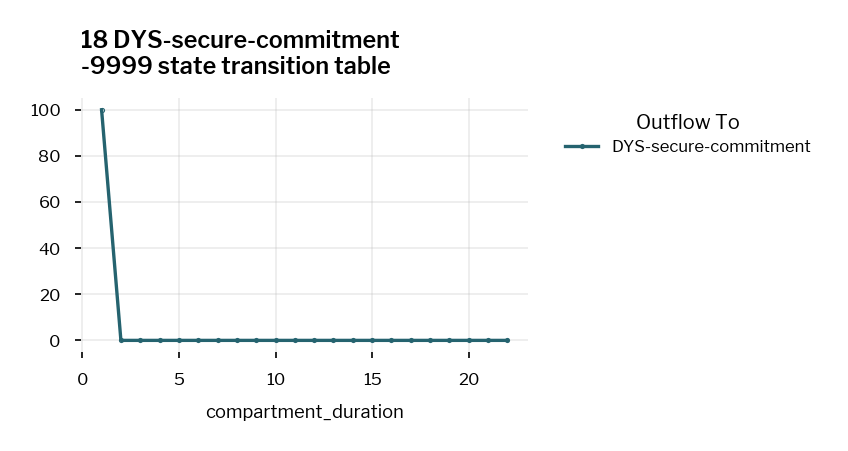

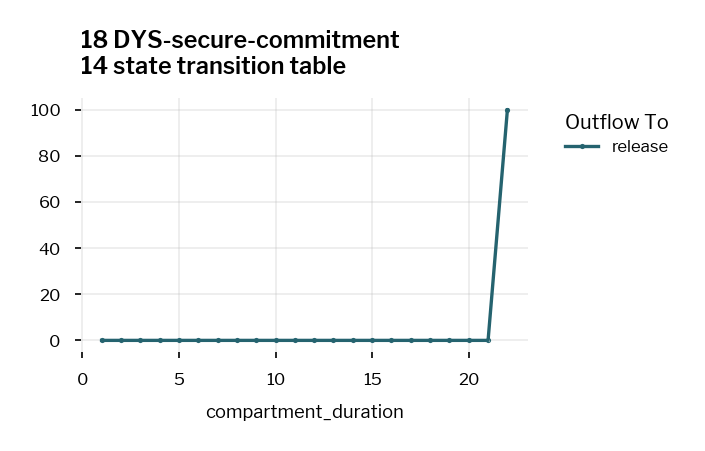

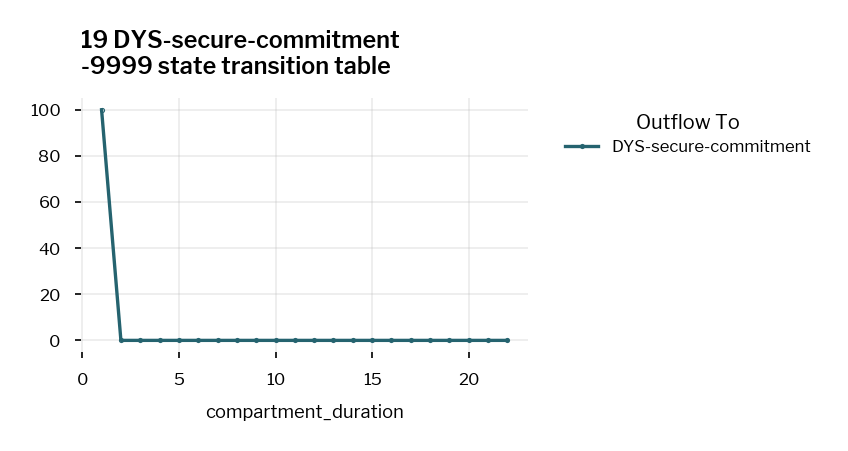

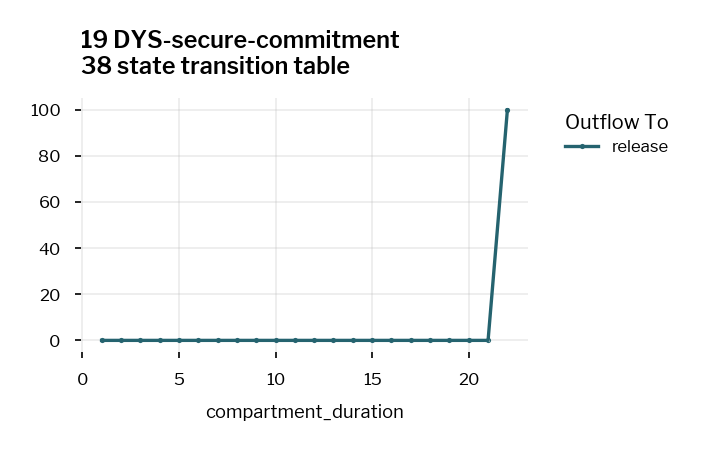

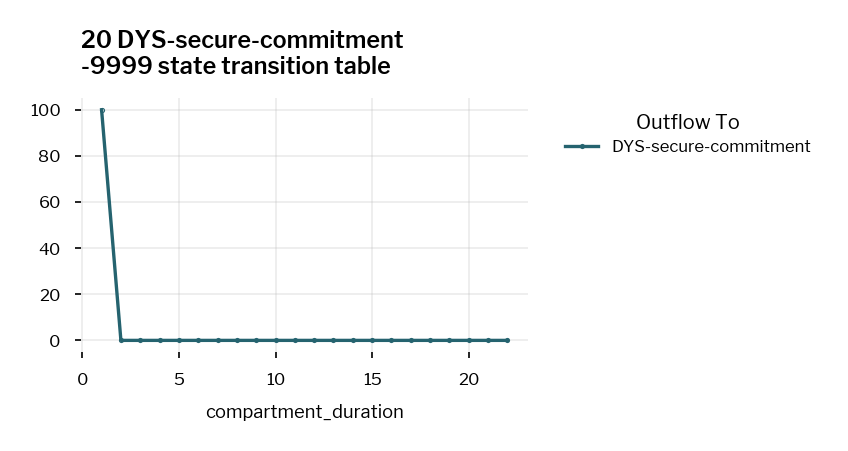

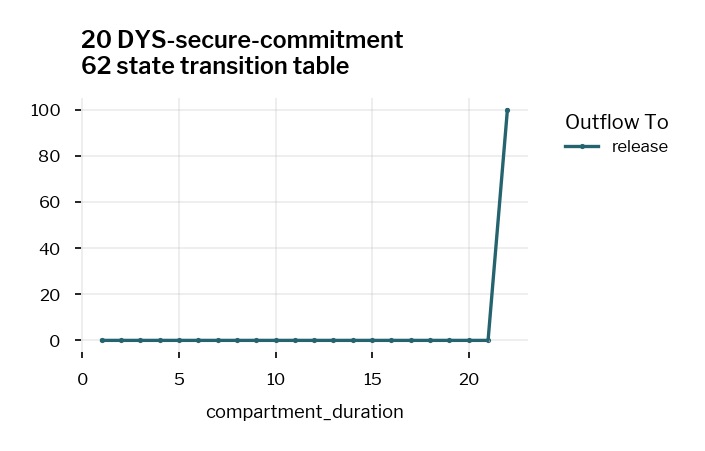

In [23]:
simulation_key = "policy"
compartment = "DYS-secure-commitment"
for age, sub_sim in policy_sim.get_population_simulations()[
    simulation_key
].sub_simulations.items():
    spark_compartment = sub_sim.simulation_compartments[compartment]

    policy_ts = max(spark_compartment.compartment_transitions.transition_tables.keys())
    print(f"policy_ts {policy_ts}")
    for (
        time_step,
        transition_df,
    ) in spark_compartment.compartment_transitions.transition_tables[
        policy_ts
    ].tables.items():
        transition_df = pd.DataFrame(
            (transition_df.drop(["remaining"], axis=1) * 100).stack("outflow_to"),
            columns=["transition_percent"],
        )
        transition_df["age"] = age
        transition_df["compartment"] = compartment
        transition_df["time_step"] = time_step
        transition_df = (
            transition_df.set_index(["time_step", "compartment", "age"], append=True)
            .reorder_levels(
                [
                    "time_step",
                    "compartment",
                    "age",
                    "compartment_duration",
                    "outflow_to",
                ]
            )
            .unstack("outflow_to")
        )

        title = f"{age} {compartment}\n{time_step} state transition table"

        ax_list = transition_df.loc[time_step, compartment, age].plot(
            y="transition_percent", title=title, marker=".", markersize=0.5
        )
        plt.legend(title="Outflow To", bbox_to_anchor=(1.05, 1), loc="upper left")

initialization time:  8.16166877746582
simulation_time:  21.824883937835693


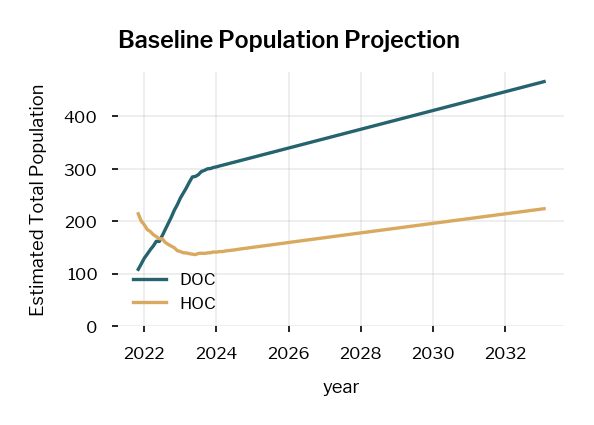

In [46]:
policy_sim.simulate_baseline(["DOC", "HOC"])

initialization time:  8.16166877746582
simulation_time:  21.824883937835693


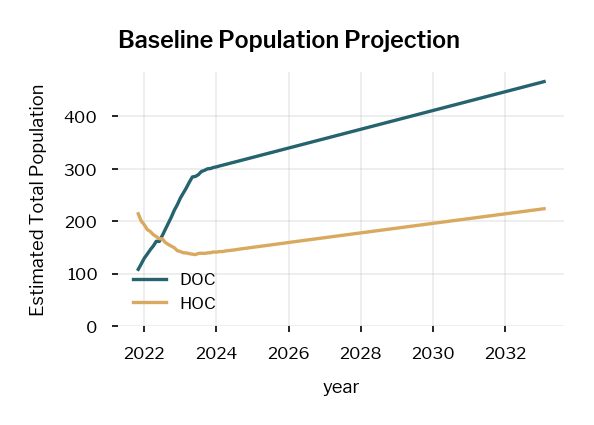

In [46]:
policy_sim.simulate_baseline(["DOC", "HOC"])

In [20]:
baseline_projection = policy_sim.get_population_simulations()[
    "control"
].get_population_projections()
baseline_outflows = policy_sim.get_population_simulations()["control"].get_outflows()
baseline_outflows.head()

total_population compartment simulation_group
outflow_to time_step                                               
filing     -50              182.229965       entry               18
           -49              187.089431       entry               18
           -48              157.932637       entry               18
           -47               82.610918       entry               18
           -46              184.659698       entry               18

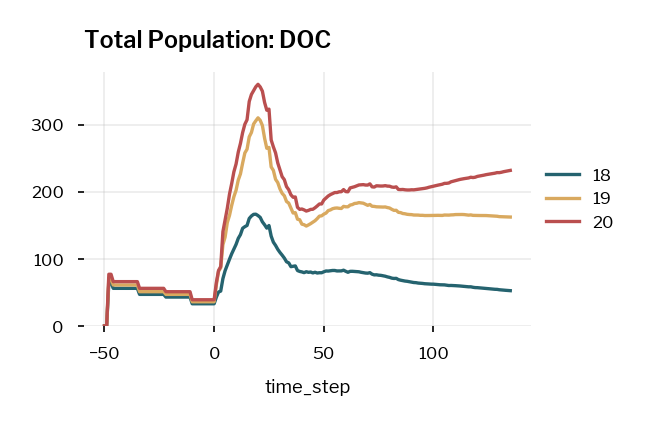

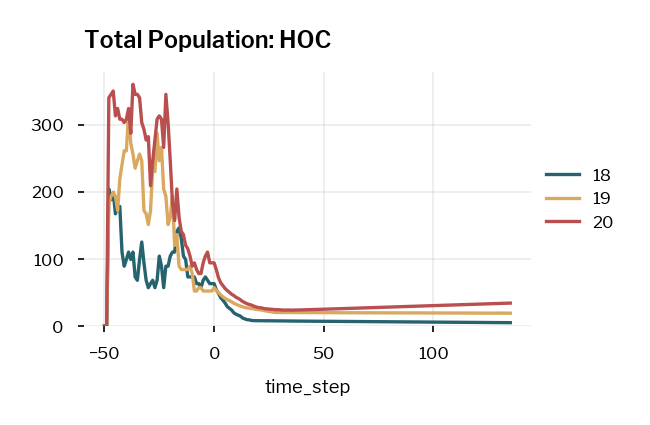

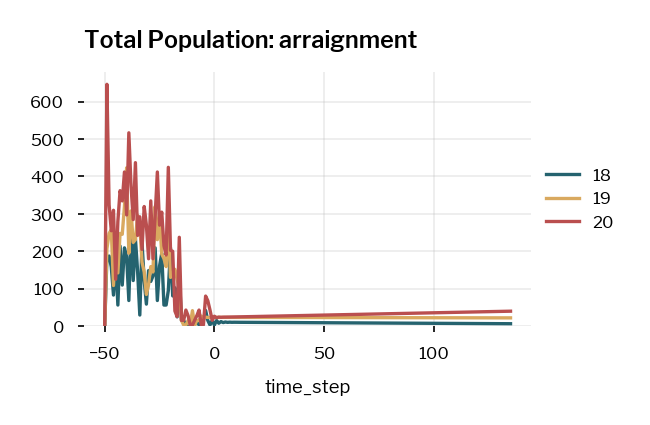

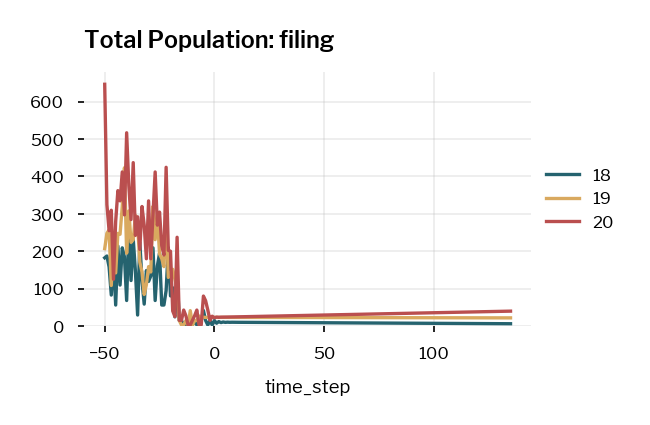

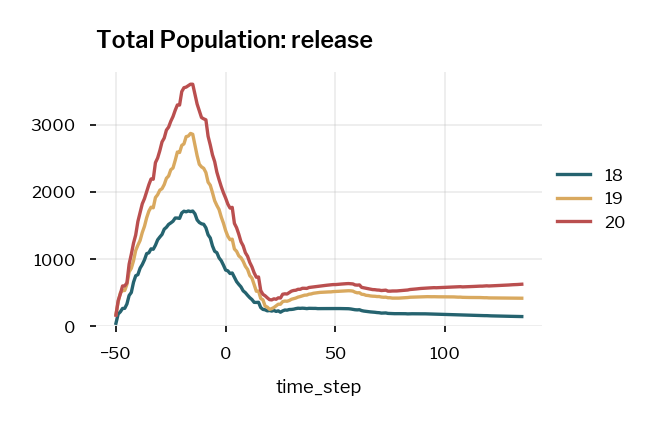

In [21]:
for compartment, df in baseline_projection.groupby("compartment"):
    if ("dys" in compartment) or ("release_full" in compartment):
        continue
    df.set_index(["time_step", "simulation_group"])["total_population"].unstack(
        "simulation_group"
    ).plot()
    add_legend()
    plt.title(f"Total Population: {compartment}")
    plt.ylim([0, None])

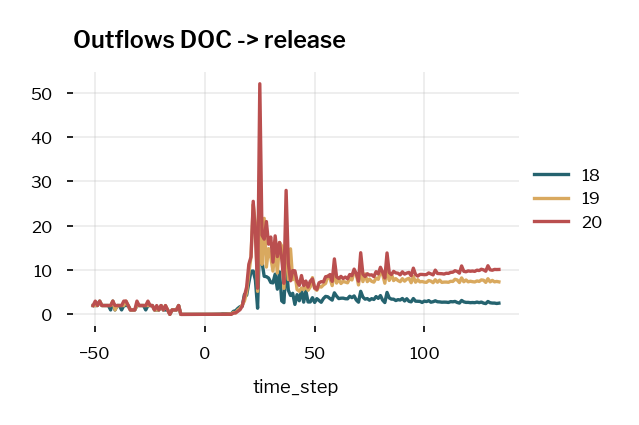

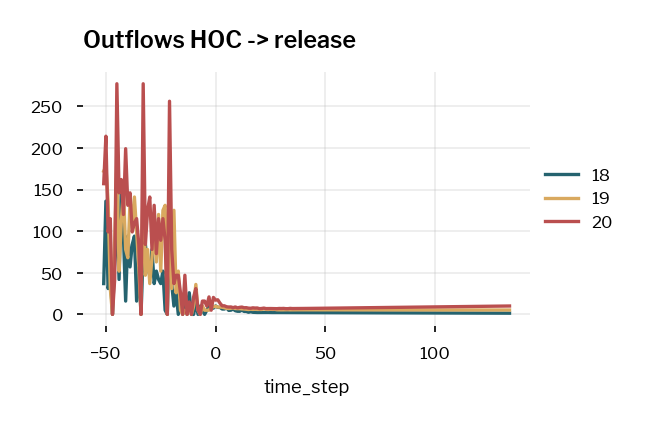

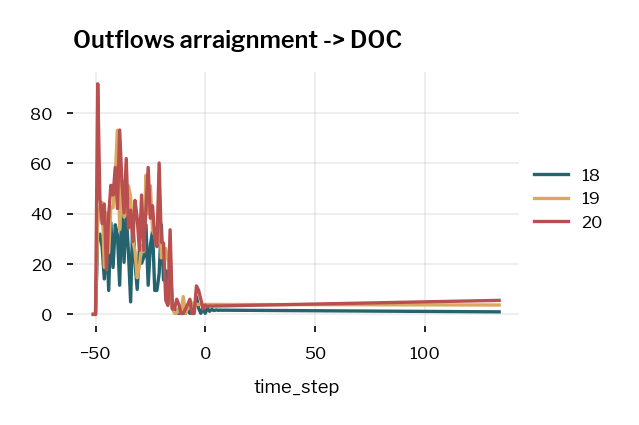

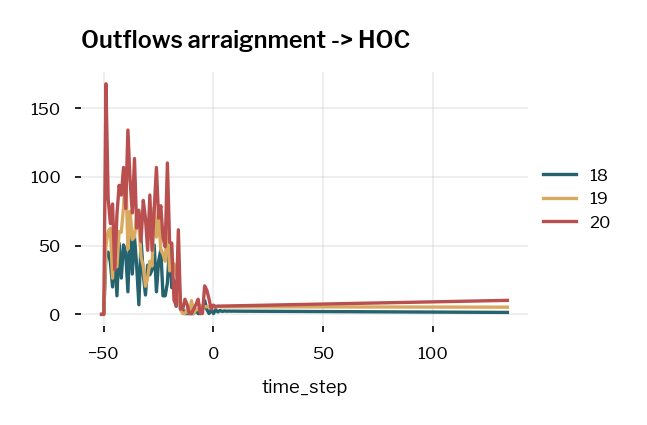

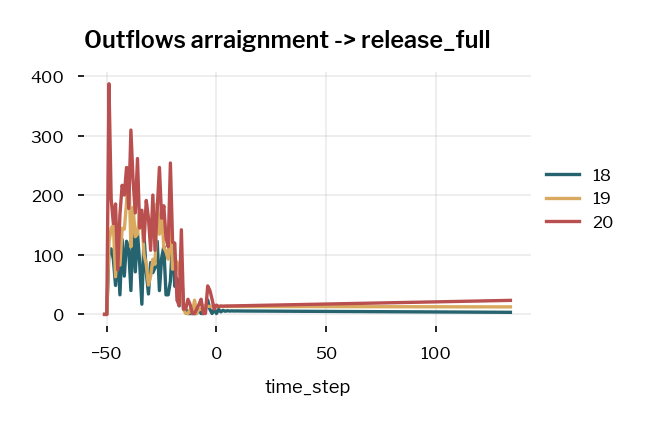

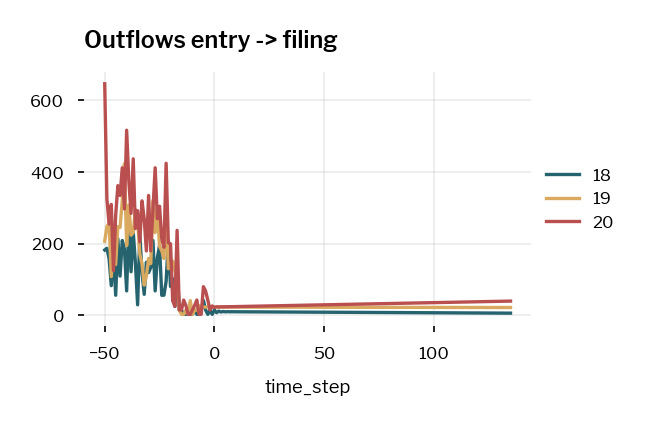

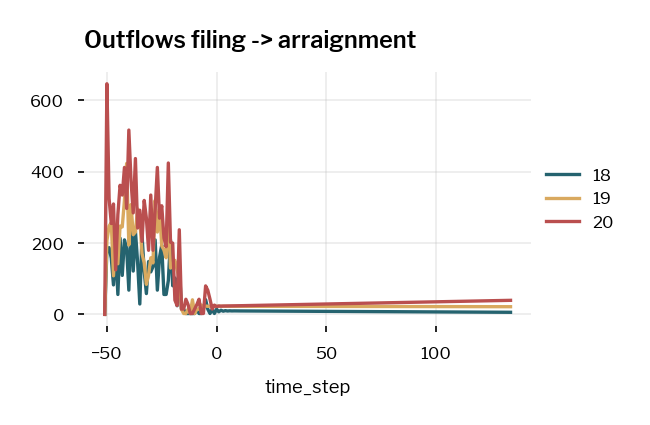

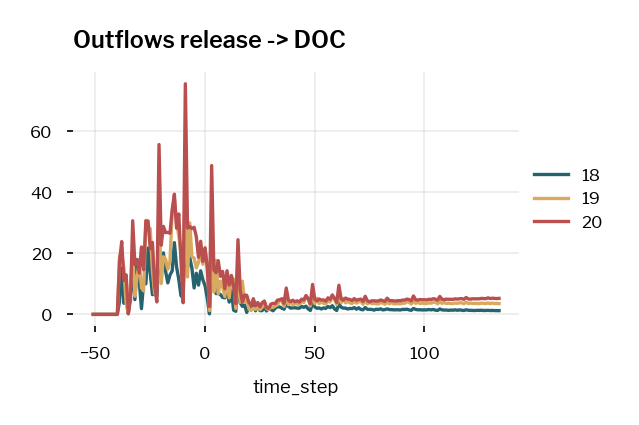

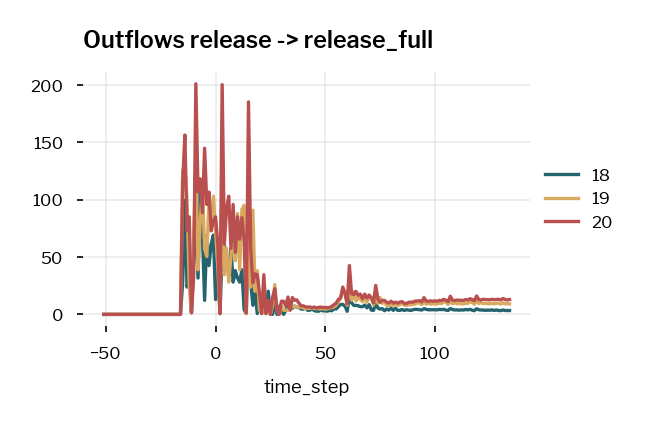

In [22]:
for (compartment, outflow_to), df in baseline_outflows.groupby(
    ["compartment", "outflow_to"]
):
    if ("dys" in compartment) or ("release_full" in compartment):
        continue
    df.set_index("simulation_group", append=True).reset_index("outflow_to")[
        "total_population"
    ].unstack("simulation_group").plot()
    add_legend()
    plt.title(f"Outflows {compartment} -> {outflow_to}")

Text(0.0, 1.0, 'Outflows entry -> filing')

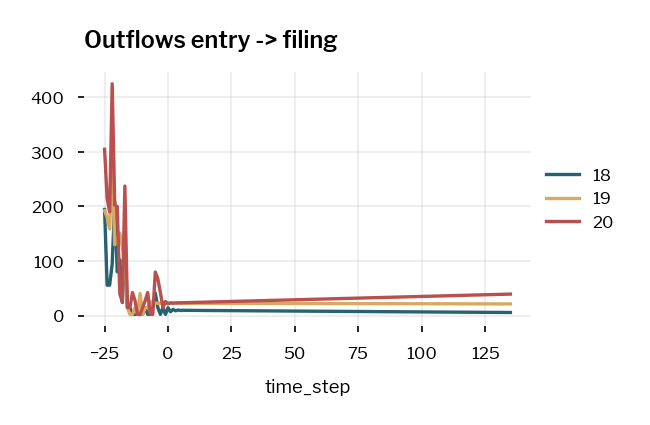

In [24]:
entry_outflows = baseline_outflows[baseline_outflows["compartment"] == "entry"]

entry_outflows_per_age = (
    entry_outflows.set_index("simulation_group", append=True)
    .reset_index("outflow_to")["total_population"]
    .unstack("simulation_group")
)
entry_outflows_per_age[
    entry_outflows_per_age.index.get_level_values("time_step") >= -25
].plot()
add_legend()
plt.title(f"Outflows entry -> filing")

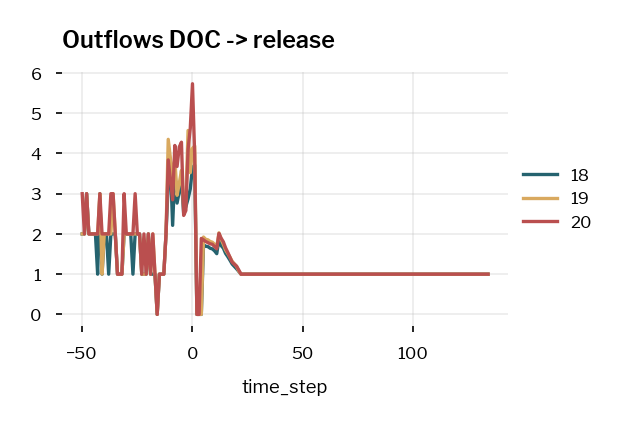

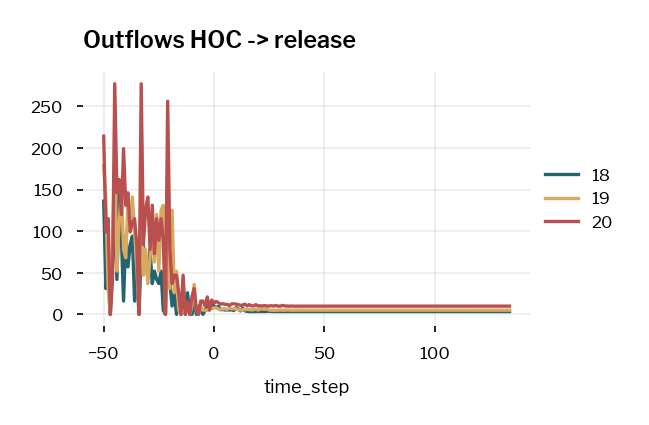

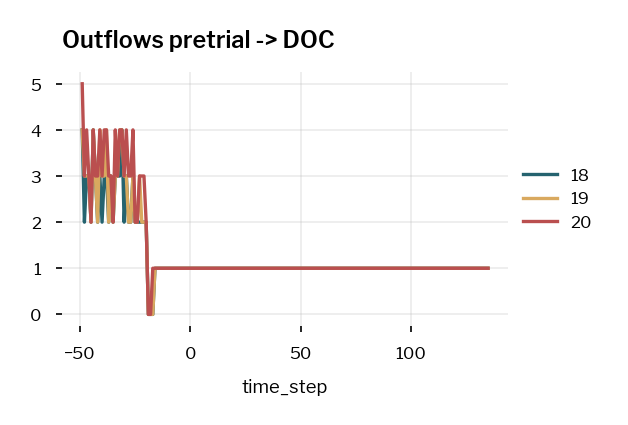

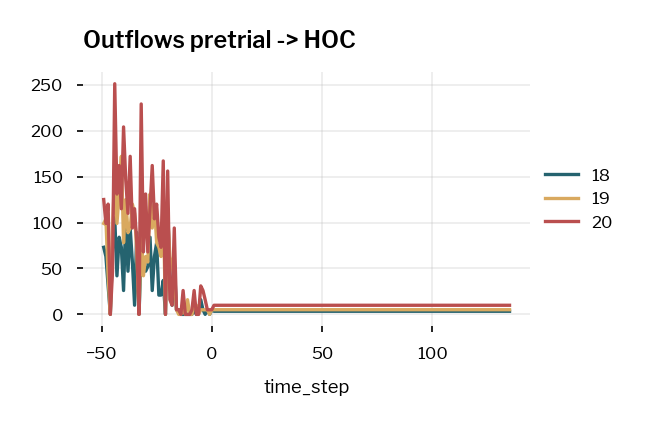

In [27]:
for (compartment, outflow_to), df in baseline_outflows.groupby(
    ["compartment", "outflow_to"]
):
    if ("DYS" in compartment) or ("release" in compartment):
        continue
    df.set_index("simulation_group", append=True).reset_index("outflow_to")[
        "total_population"
    ].unstack("simulation_group").plot()
    add_legend()
    plt.title(f"Outflows {compartment} -> {outflow_to}")

In [23]:
data_inputs = policy_sim.initializer.get_data_inputs()
data_inputs.keys()

dict_keys(['outflows_data', 'transitions_data', 'total_population_data', 'compartments_architecture', 'disaggregation_axes', 'microsim_data', 'should_initialize_compartment_populations', 'should_scale_populations_after_step', 'override_cross_flow_function'])

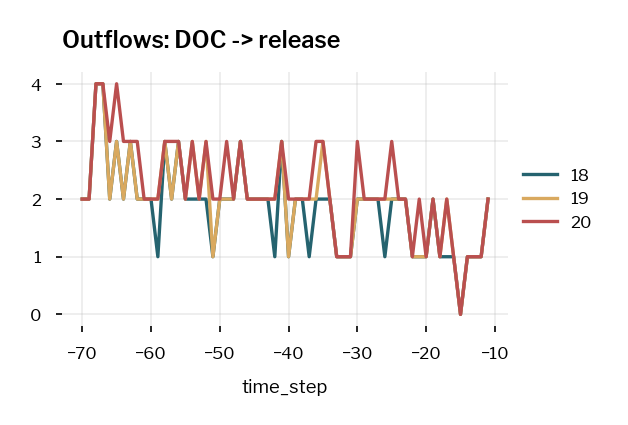

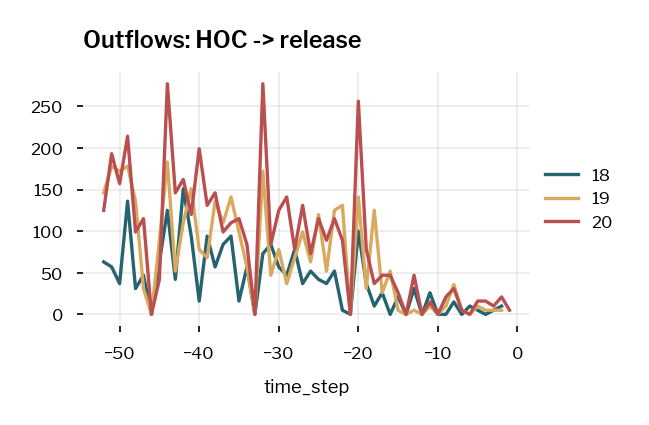

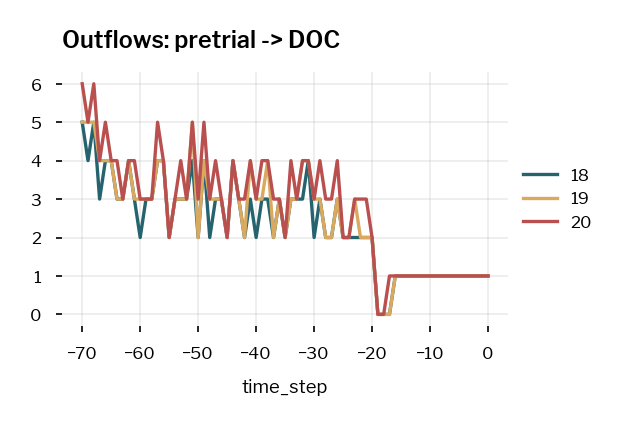

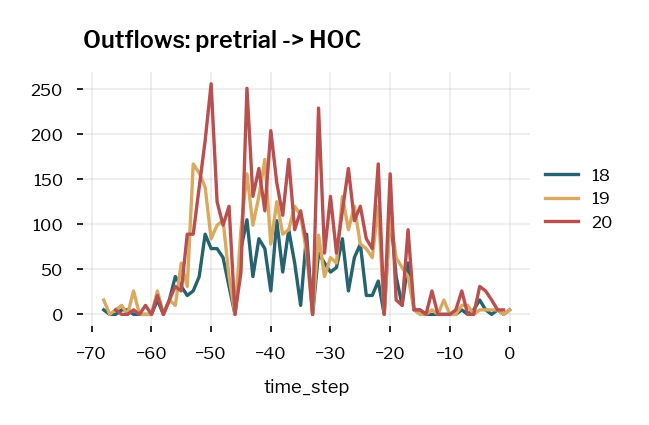

In [28]:
outflows = data_inputs.outflows_data
# outflows = outflows.set_index(["compartment", "outflow_to", "time_step", "age"])
for (compartment, outflow_to), df in outflows.groupby(["compartment", "outflow_to"]):
    df.groupby(["time_step", "age"]).sum()["total_population"].unstack("age").plot()
    plt.title(f"Outflows: {compartment} -> {outflow_to}")
    add_legend()

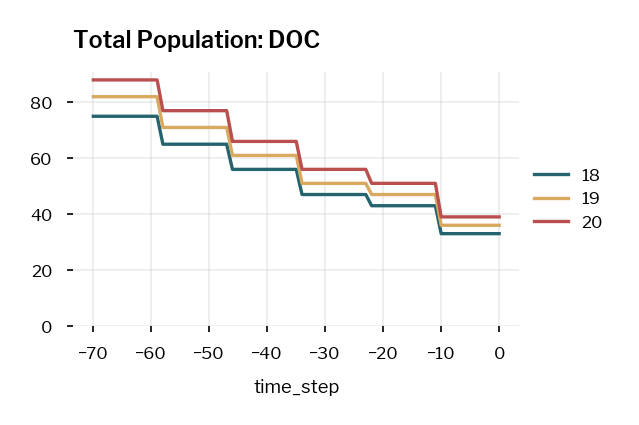

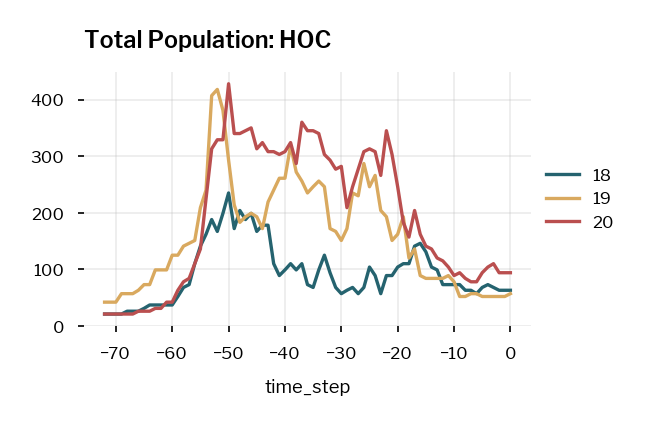

In [30]:
total_population = data_inputs.total_population_data
# outflows = outflows.set_index(["compartment", "outflow_to", "time_step", "age"])
for (compartment), df in total_population.groupby("compartment"):
    df.set_index(["time_step", "age"])["total_population"].unstack("age").plot()
    plt.title(f"Total Population: {compartment}")
    plt.ylim([0, None])
    add_legend()

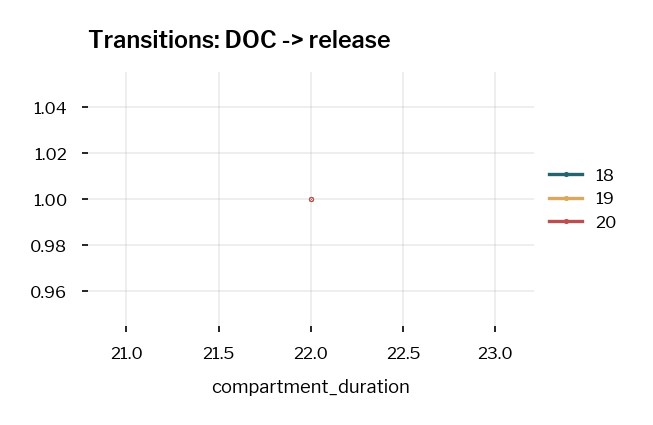

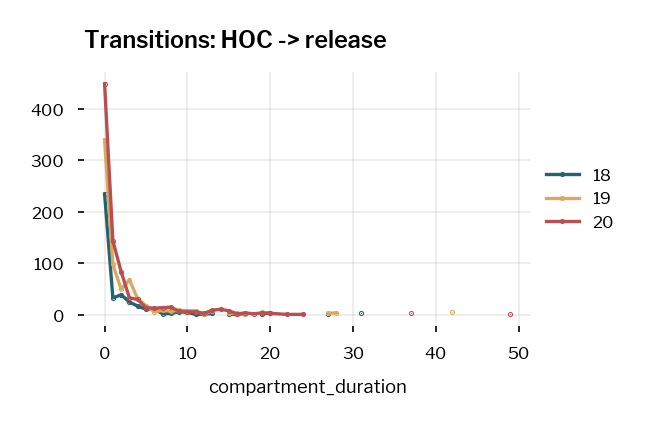

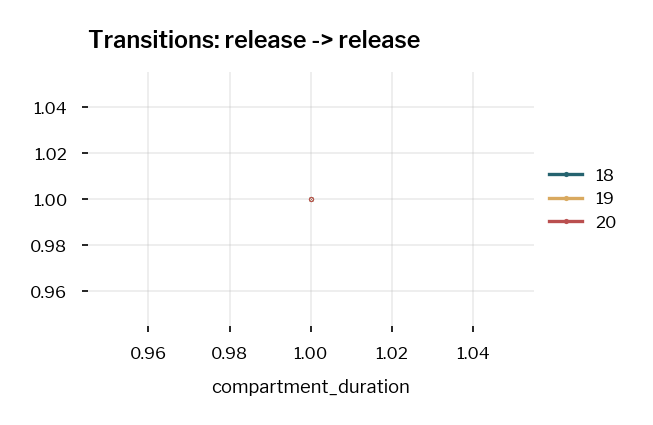

In [32]:
transitions = data_inputs["transitions_data"]
# outflows = outflows.set_index(["compartment", "outflow_to", "time_step", "age"])
for (compartment, outflow_to), df in transitions.groupby(["compartment", "outflow_to"]):
    df.set_index(["compartment_duration", "age"])["total_population"].unstack(
        "age"
    ).plot(marker=".", markersize="0.5")
    plt.title(f"Transitions: {compartment} -> {outflow_to}")
    add_legend()

In [87]:
policy_outflows = policy_sim.get_population_simulations()["policy"].get_outflows()
policy_outflows.head()

total_population compartment simulation_group
outflow_to time_step                                               
filing     -50              182.229965       entry               18
           -49              187.089431       entry               18
           -48              157.932637       entry               18
           -47               82.610918       entry               18
           -46              184.659698       entry               18

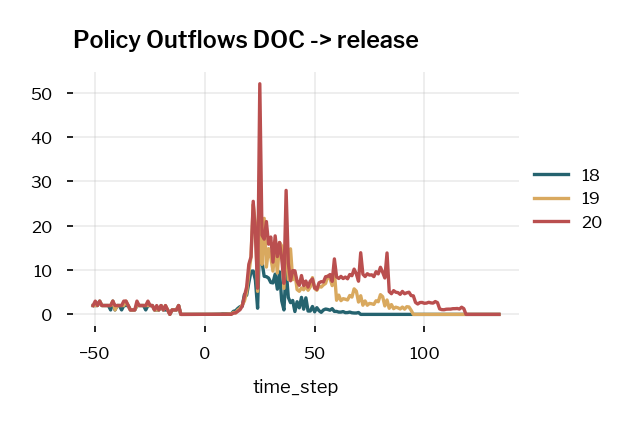

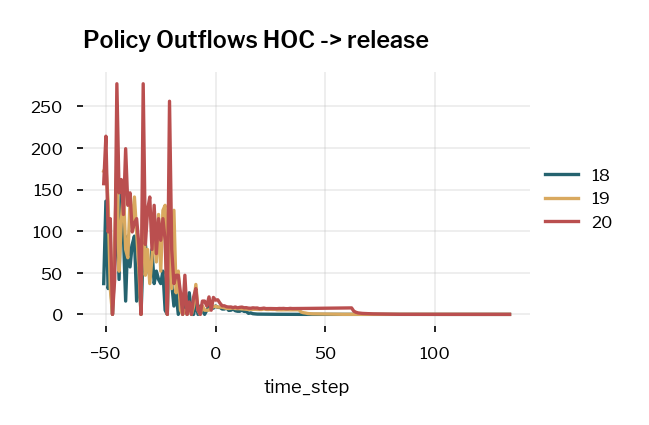

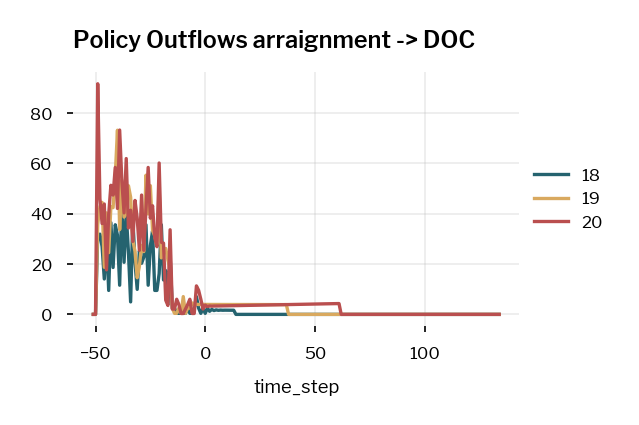

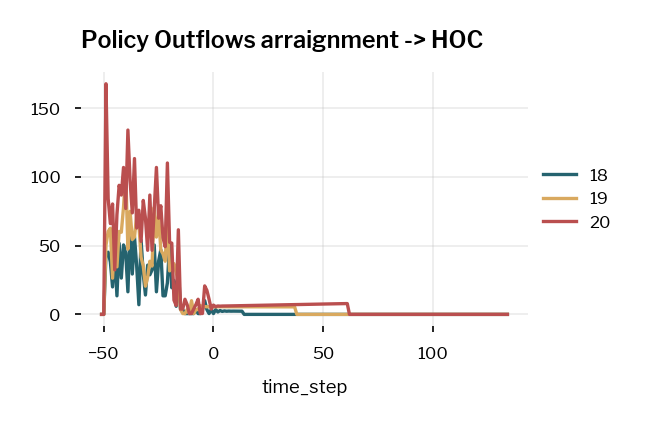

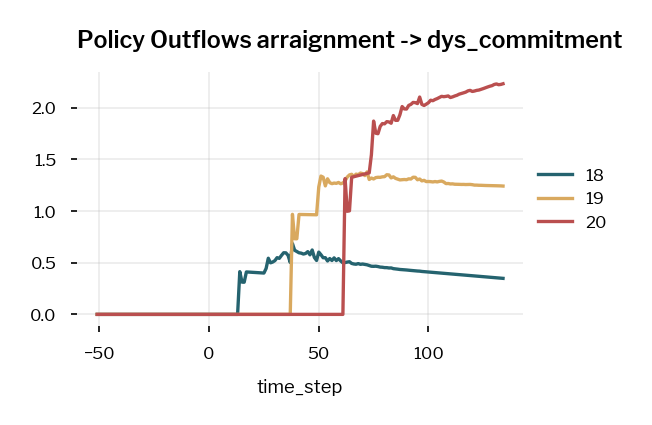

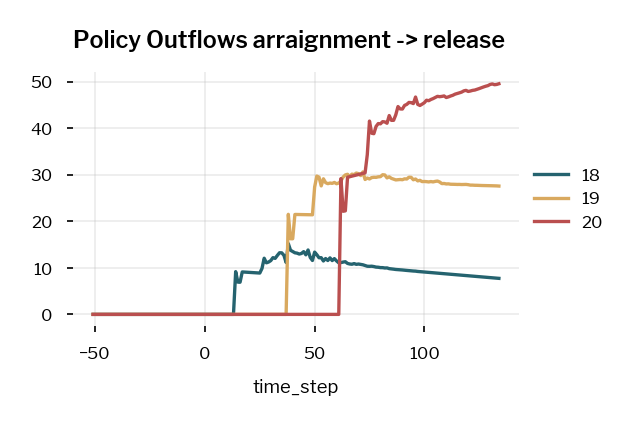

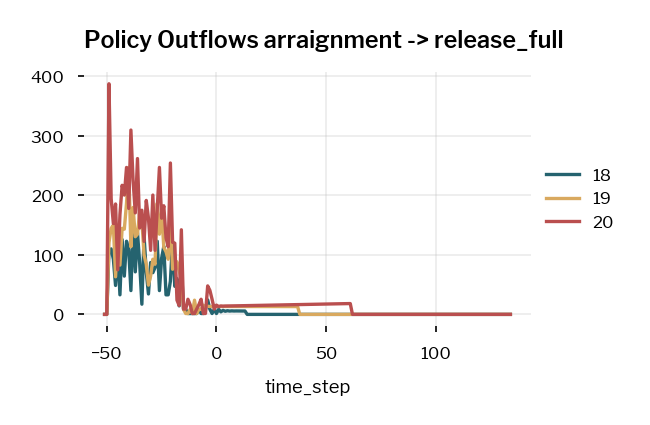

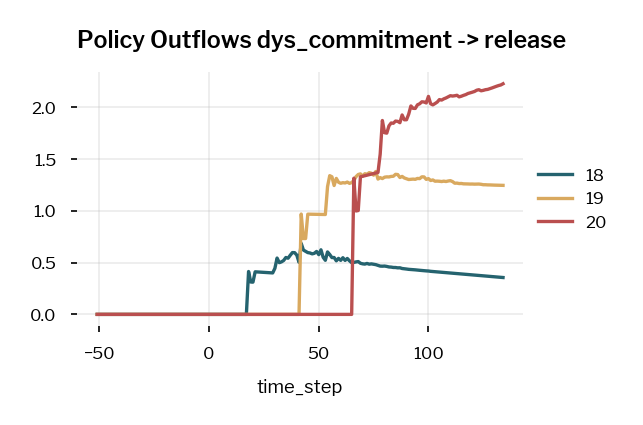

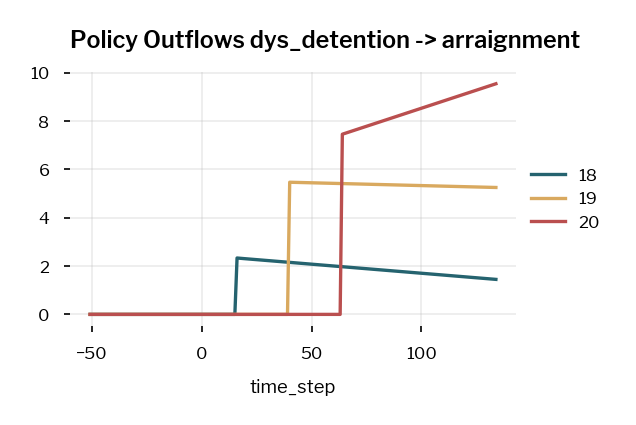

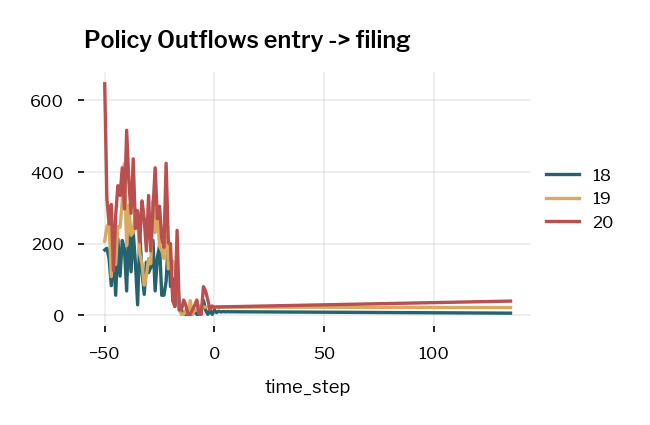

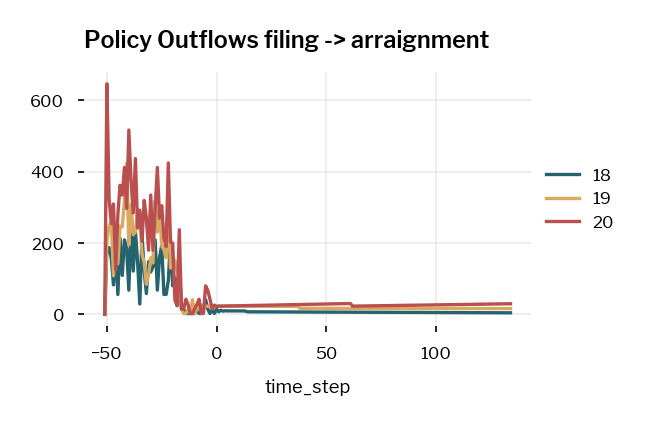

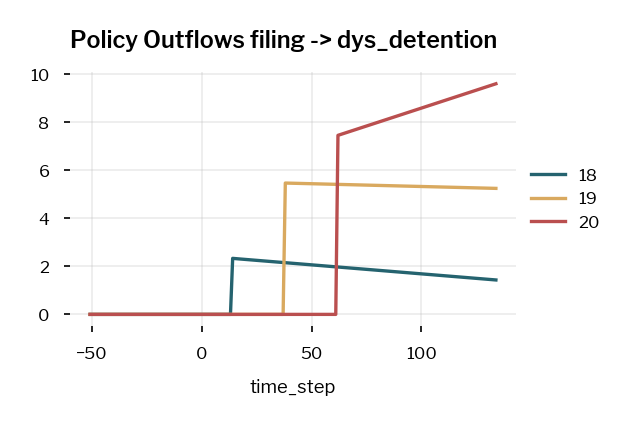

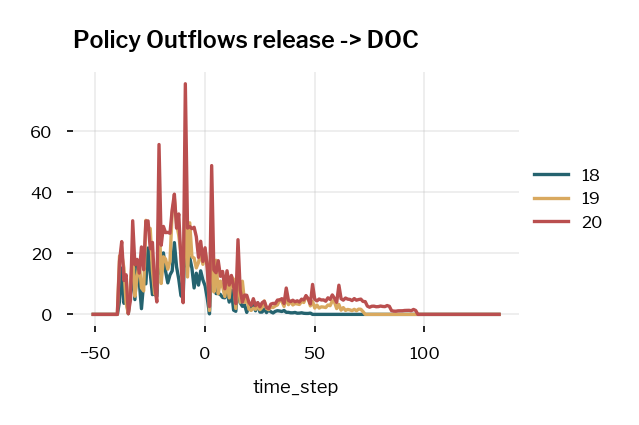

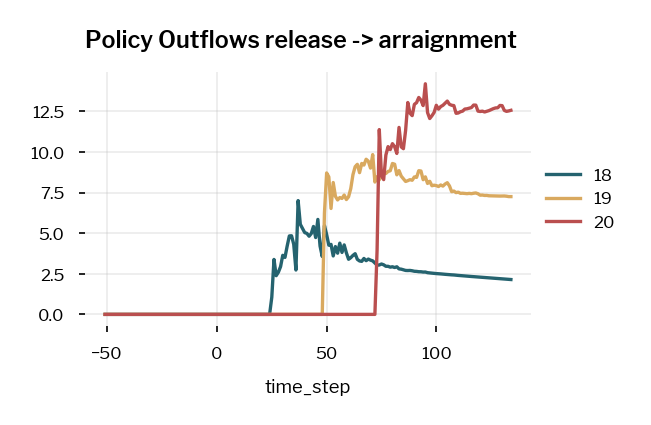

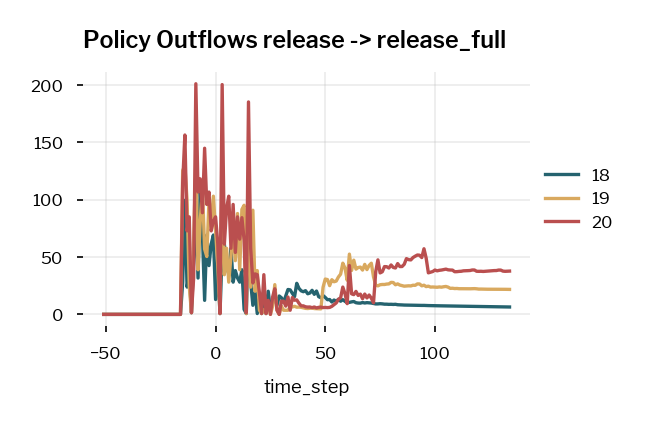

In [88]:
for (compartment, outflow_to), df in policy_outflows.groupby(
    ["compartment", "outflow_to"]
):
    if "release_full" in compartment:
        continue
    df.set_index("simulation_group", append=True).reset_index("outflow_to")[
        "total_population"
    ].unstack("simulation_group").plot()
    add_legend()
    plt.title(f"Policy Outflows {compartment} -> {outflow_to}")